In [ ]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [ ]:
TEMPERATURES_CSV = './data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In [ ]:
import pandas as pd
q=pd.read_csv(TEMPERATURES_CSV)
q.index

RangeIndex(start=0, stop=3650, step=1)

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:

        reader = csv.reader(csvfile, delimiter= ',')
        next(reader)
        
        for num in range(0,3650,1):
            times.append (num)
            
        for row in reader:
            temperatures.append(float(row[1]))
 
    return times, temperatures

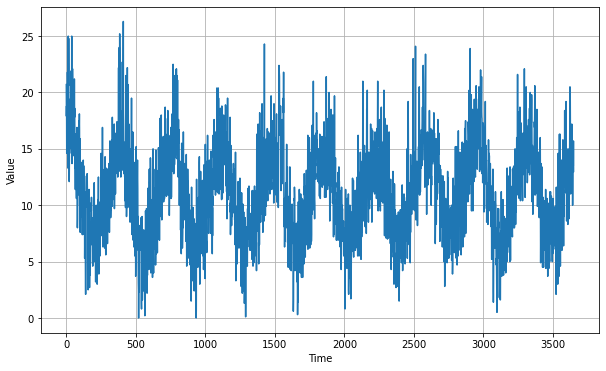

In [ ]:
@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 256
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [ ]:
def create_uncompiled_model():
   
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(64,3,input_shape=[G.WINDOW_SIZE,1]),
            tf.keras.layers.LSTM(32,return_sequences=True),
            tf.keras.layers.LSTM(32),
            tf.keras.layers.Dense(10,activation='relu'),
            tf.keras.layers.Dense(10,activation='relu'),
            tf.keras.layers.Dense(1)
    ]) 
    
    return model

In [ ]:
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Your current architecture is compatible with the windowed dataset! :)


In [ ]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    optimizer = 'adam'

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [ ]:
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
10/10 [==============================] - 5s 181ms/step - loss: 10.1952 - mae: 10.6941 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - 2s 171ms/step - loss: 10.1274 - mae: 10.6262 - lr: 1.1220e-04
Epoch 3/100
10/10 [==============================] - 2s 171ms/step - loss: 10.0684 - mae: 10.5672 - lr: 1.2589e-04
Epoch 4/100
10/10 [==============================] - 2s 178ms/step - loss: 9.9922 - mae: 10.4909 - lr: 1.4125e-04
Epoch 5/100
10/10 [==============================] - 2s 177ms/step - loss: 9.8981 - mae: 10.3967 - lr: 1.5849e-04
Epoch 6/100
10/10 [==============================] - 2s 178ms/step - loss: 9.7829 - mae: 10.2816 - lr: 1.7783e-04
Epoch 7/100
10/10 [==============================] - 2s 177ms/step - loss: 9.6472 - mae: 10.1457 - lr: 1.9953e-04
Epoch 8/100
10/10 [==============================] - 2s 177ms/step - loss: 9.4285 - mae: 9.9267 - lr: 2.2387e-04
Epoch 9/100
10/10 [==============================] - 2s 170ms/step - loss: 9.0144 - ma

(0.0001, 10.0, 0.0, 10.0)

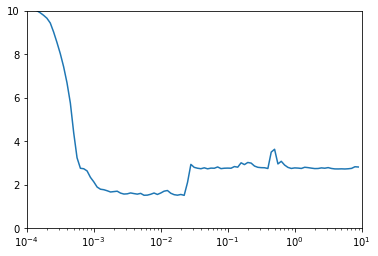

In [ ]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

In [ ]:
def create_model():

    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer='adam',
                  metrics=['mae'])  

    return model

In [ ]:
model = create_model()

history = model.fit(train_set, epochs=50)

Epoch 1/50
10/10 [==============================] - 5s 161ms/step - loss: 10.2885 - mae: 10.7875
Epoch 2/50
10/10 [==============================] - 2s 157ms/step - loss: 10.1614 - mae: 10.6602
Epoch 3/50
10/10 [==============================] - 2s 158ms/step - loss: 9.8534 - mae: 10.3519
Epoch 4/50
10/10 [==============================] - 2s 156ms/step - loss: 9.4763 - mae: 9.9748
Epoch 5/50
10/10 [==============================] - 2s 157ms/step - loss: 9.0211 - mae: 9.5195
Epoch 6/50
10/10 [==============================] - 2s 155ms/step - loss: 8.4852 - mae: 8.9832
Epoch 7/50
10/10 [==============================] - 2s 157ms/step - loss: 7.8912 - mae: 8.3873
Epoch 8/50
10/10 [==============================] - 2s 158ms/step - loss: 7.2963 - mae: 7.7922
Epoch 9/50
10/10 [==============================] - 2s 158ms/step - loss: 6.6936 - mae: 7.1872
Epoch 10/50
10/10 [==============================] - 2s 165ms/step - loss: 6.0715 - mae: 6.5618
Epoch 11/50
10/10 [=========================

In [ ]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

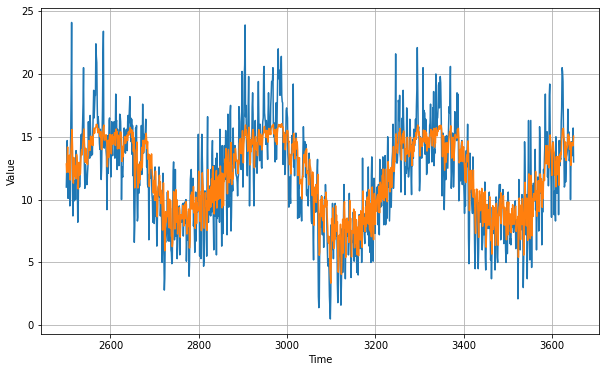

In [ ]:
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.64, mae: 1.85 for forecast


In [ ]:
model.save('saved_model/my_model')

! tar -czvf saved_model.tar.gz saved_model/

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


saved_model/
saved_model/my_model/
saved_model/my_model/keras_metadata.pb
saved_model/my_model/variables/
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/variables/variables.index
saved_model/my_model/saved_model.pb
saved_model/my_model/assets/
